# Volatility Strategy

In [97]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
from volatility_model.loader import download_data, save_to_csv, load_from_csv
import numpy as np
import pandas as pd

In [98]:
# df = download_data('SPY', start='2010-01-01')
# df.head()
from volatility_model.loader import load_from_csv
import yfinance as yf
df = load_from_csv('../data/spy_returns.csv')



In [99]:
df.head()

,price,High_SPY,Low_SPY,Open_SPY,Volume_SPY,log_return
Date,,,,,,
2010-01-05,85.742012,85.779743,85.153447,85.462824,111579900,0.002644
2010-01-06,85.802345,86.013624,85.591066,85.658975,116074400,0.000703
2010-01-07,86.164566,86.270206,85.402447,85.643910,131091100,0.004213
2010-01-08,86.451294,86.489025,85.764637,85.938185,126402800,0.003322
2010-01-11,86.572067,86.873892,86.202323,86.836166,106375700,0.001396


In [100]:
df.columns

Index(['price', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'log_return'], dtype='object')

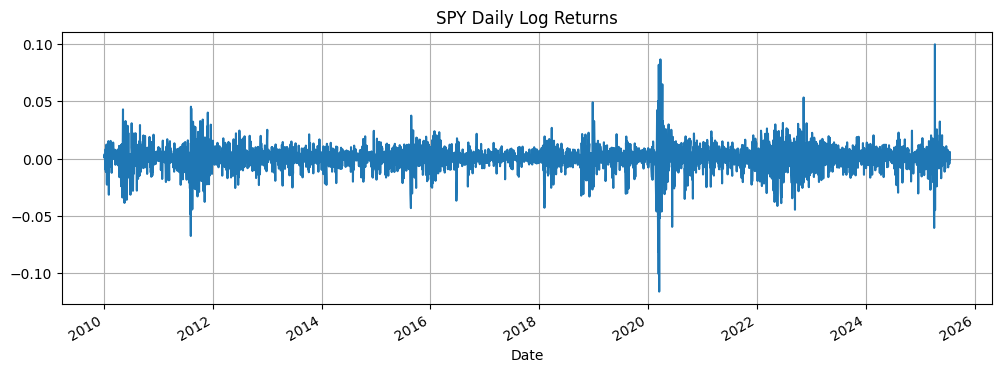

In [101]:
import matplotlib.pyplot as plt

df['log_return'].plot(figsize=(12, 4), title='SPY Daily Log Returns')
plt.grid(True)
plt.show()

In [102]:
df['log_return'].tail()

Date
2025-07-14    0.001906
2025-07-15   -0.004282
2025-07-16    0.003338
2025-07-17    0.006101
2025-07-18   -0.000733
Name: log_return, dtype: float64

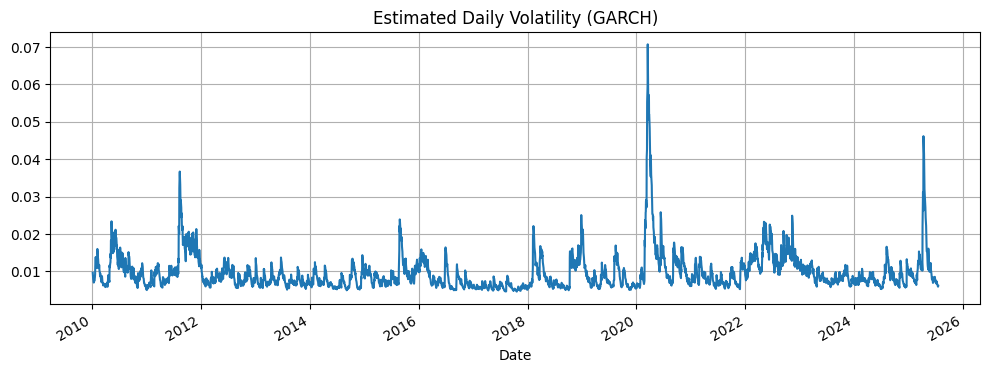

In [103]:
from volatility_model.garch_model import fit_garch_model

# Step 2: Fit GARCH(1,1) model
res, vol_series = fit_garch_model(df['log_return'])

# Merge volatility with price/returns
df['garch_vol'] = vol_series

# Step 3: Plot GARCH-estimated volatility
df['garch_vol'].plot(figsize=(12, 4), title='Estimated Daily Volatility (GARCH)')
plt.grid(True)
plt.show()


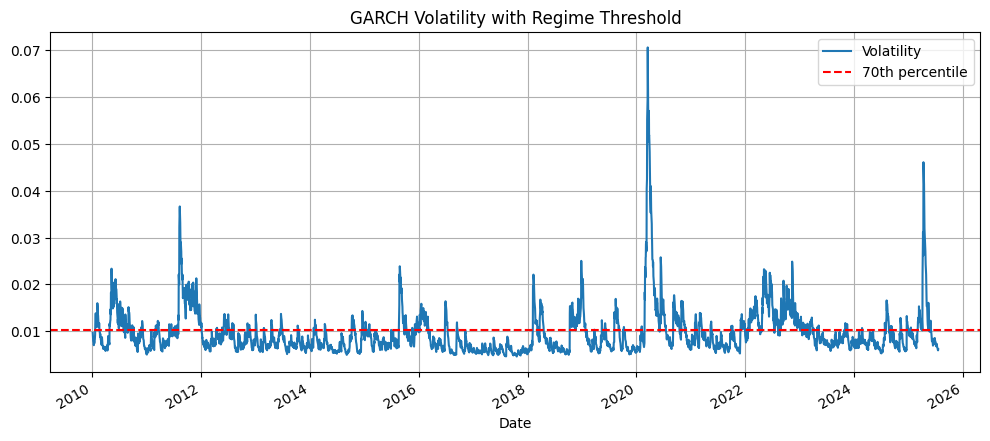

In [104]:
from volatility_model.strategy import classify_volatility_regimes

df = classify_volatility_regimes(df, vol_col='garch_vol', threshold_quantile=0.7)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
df['garch_vol'].plot(label='Volatility')
plt.axhline(df['garch_vol'].quantile(0.7), color='red', linestyle='--', label='70th percentile')
plt.title('GARCH Volatility with Regime Threshold')
plt.legend()
plt.grid(True)
plt.show()


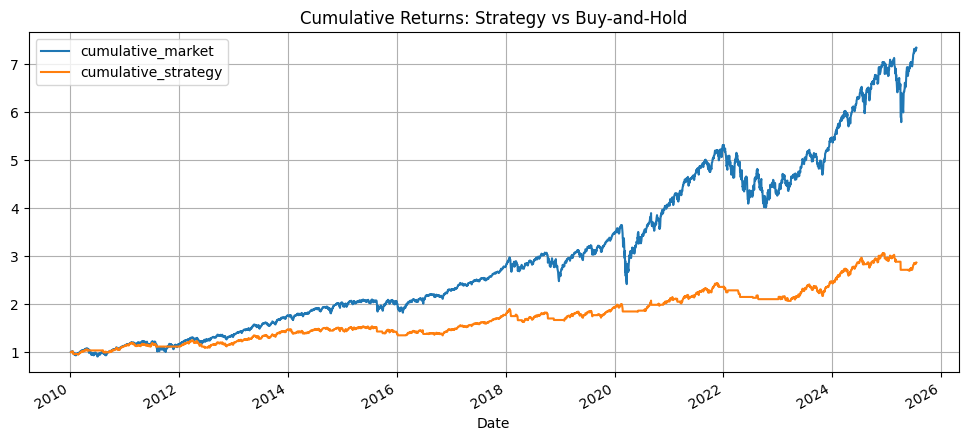

In [105]:
# if vol is low, we go long; if vol is high, we stay in cash 
df['position'] = df['vol_regime'].map({'low': 1.0, 'high': 0.0})
df['strategy_return'] = df['position'].shift(1) * df['log_return']

# Cumulative returns
df['cumulative_strategy'] = df['strategy_return'].cumsum().apply(np.exp)
df['cumulative_market'] = df['log_return'].cumsum().apply(np.exp)

# Step 6: Plot performance
df[['cumulative_market', 'cumulative_strategy']].plot(figsize=(12, 5), title='Cumulative Returns: Strategy vs Buy-and-Hold')
plt.grid(True)
plt.show()



Blue Line: Buy-and-hold SPY — higher total return, but large drawdowns (e.g., 2020 crash, 2022 dip)

Orange Line: Your GARCH-based strategy — smoother, smaller drawdowns, but lower final return

In [106]:
from volatility_model.strategy import compute_performance_metrics

# Market (buy-and-hold)
market_metrics = compute_performance_metrics(df, return_col='log_return')
strategy_metrics = compute_performance_metrics(df, return_col='strategy_return')

pd.DataFrame([market_metrics, strategy_metrics], index=['Buy and Hold', 'GARCH Strategy'])


,CAGR,Volatility,Sharpe Ratio,Max Drawdown
Buy and Hold,0.136926,0.173920,0.738996,-0.337173
GARCH Strategy,0.070171,0.099619,0.681996,-0.149767


A lower return but higher Sharpe ratio and lower drawdown means the GARCH strategy may be better for risk-averse investors 